In [1]:
"""
The following code shows how to analyze the accuracy of LSTM based on the size of portfolio K (Top K to long, bottom K to short).
We select K = [10,50,100,150,200] and we realize that the accuracy is the highest when K =10. Hence, we will continue our backtestubg using K = 10.
Furthermore, we have listed the accuracy of 10 sectors when k = 10 (ignore Real Estate due to small sample size)
We have realized that our LSTM model does not have a sector preference.

"""

import pandas as pd
import statistics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def count_accu(K,df):
    count = 0
    for i in range(K):
        if df.iloc[i,-1] == df.iloc[i,-2]:
            count+=1
    for i in range(K):
        if df.iloc[-(i+1),-1]== df.iloc[-(i+1),-2]:
            count+=1
    return count

def classification(y):
    if y >=0.5:
        return 1
    else:
        return 0

def rebalance_freq(ds_1,ds_2):
    ds = pd.concat([ds_1,ds_2],axis = 0,ignore_index = True).reset_index(drop = True)
    unique_length = len(ds.value_counts().keys().tolist())
    non_unique = ds.size- unique_length
    rebalance_percentage = (ds_1.size-non_unique)/(ds_1.size)
    return rebalance_percentage


     
data = pd.read_csv('C:/Users/Yu/Desktop/pred_result.csv',index_col = 0)
data['y_pred'] = data['y_prob'].apply(classification)
data = data.sort_values(['Date','y_prob'],ascending = True)
date_list = list(data.Date.unique())
data = data[['Date','Ticker','Sector','y_prob','y_pred','y_true']]
data = data.reset_index(drop = True)
# Overall accuracy of LSTM model
K = [10,50,100,150,200]
for k in K:
    accuracy_list = []
    for date in date_list:
        data_date = data[data.Date == date]
        data_date = data_date.reset_index(drop = True)
        accu_item = count_accu(k,data_date)
        accuracy_date = accu_item/(2*k)
        accuracy_list.append(accuracy_date)
    accuracy = round(sum(accuracy_list)/len(accuracy_list),4)
    if k == 10:
        overall_accuracy = accuracy
    print('Overall accuracy for K = '+str(k)+' is '+str(accuracy))
    
# Accuracy analysis for each sectors when K = 10
sector = list(data.Sector.unique())
del(sector[-1])

sec_dict = {}
for sec in sector:
    data_sector = data[data.Sector == sec]
    data_sector = data_sector.reset_index(drop =True)
    sec_accuracy_list = []
    for date in date_list:
        data_sector_date = data_sector[data_sector.Date == date]
        data_sector_date = data_sector_date.reset_index(drop =True)
        if data_sector_date.shape[0] >=20:
            accu_item = count_accu(10,data_sector_date)
            accuracy_date = accu_item/20
            sec_accuracy_list.append(accuracy_date)
    sec_accuracy  = round(sum(sec_accuracy_list)/len(sec_accuracy_list),4)
    sec_dict.update({sec:sec_accuracy})
    print('Accuracy for sector '+sec  +' is '+str(sec_accuracy) +' when K = 10')

sec_dict.update({'Overall':overall_accuracy})

C:\Users\Yu\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Overall accuracy for K = 10 is 0.5134
Overall accuracy for K = 50 is 0.5086
Overall accuracy for K = 100 is 0.5072
Overall accuracy for K = 150 is 0.5059
Overall accuracy for K = 200 is 0.5043
Accuracy for sector Industrials is 0.5053 when K = 10
Accuracy for sector Health Care is 0.5082 when K = 10
Accuracy for sector Information Technology is 0.5087 when K = 10
Accuracy for sector Financials is 0.5046 when K = 10
Accuracy for sector Consumer Discretionary is 0.5076 when K = 10
Accuracy for sector Consumer Staples is 0.5008 when K = 10
Accuracy for sector Communication Services is 0.5054 when K = 10
Accuracy for sector Materials is 0.5043 when K = 10
Accuracy for sector Energy is 0.5081 when K = 10
Accuracy for sector Real Estate is 0.4944 when K = 10


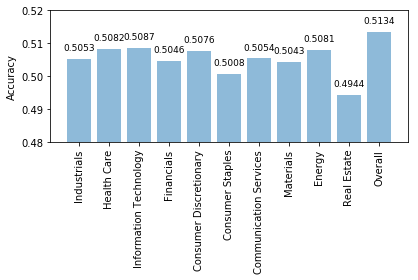

In [2]:
# Plot bar chart of overall prediction accuracy and accuracy for each sector when K = 10.
accuracy_ar = sec_dict.values()
sector_ar = sec_dict.keys()
plt.bar(sector_ar,accuracy_ar,align='center', alpha=0.5)
plt.ylim([0.48,0.52])
plt.xticks(rotation=90)
for a,b in zip(sector_ar,accuracy_ar):
    plt.text(a, b+0.002,"%.4f"%b, ha='center', va= 'bottom',fontsize=9)
plt.ylabel('Accuracy')
plt.tight_layout()
#plt.savefig('C:/Users/Yu/Desktop/Accuracy For Each Sector And All Stocks When K = 10.png')
plt.show()



In [4]:

"""
The following code shows that how we backtest different trading strategies (130-30, market neutral (50-50), long only) with each stock equally weighted.
We calculate the profits without transaction cost at first.
Then, we assume the transaction cost equals to 2bps for market neutral and 130-30 strategies and 1bps for long only portfolio.

"""
return_info = pd.read_csv('C:/Users/Yu/Desktop/return.csv',index_col = 0)
return_info = return_info[['Date','New_Ticker','Price_Return']]
return_info.columns = ['Date','Ticker','Price_Return']

# equal-weighted long only portfolio, prior to transaction cost and after transaction cost
long_only_profit_nocost = {}
long_only_accuprofit_nocost = {}
long_only_nocost_accu_profit = 1

long_only_profit_cost = {}
long_only_accuprofit_cost = {}
long_only_cost_accu_profit = 1
for date in date_list[:-1]:
    data_date = data[data.Date == date]
    long_part = data_date.iloc[-10:]
    long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
    daily_profit = long_df['Price_Return'].mean()
    long_only_nocost_accu_profit += daily_profit
    long_only_profit_nocost.update({date:daily_profit})
    long_only_accuprofit_nocost.update({date:long_only_nocost_accu_profit})
    
    date_index = date_list.index(date)
    long_part_next = data[data.Date == date_list[date_index+1]].iloc[-10:]
    ds_1 = long_part['Ticker']
    ds_2 = long_part_next['Ticker'] 
    daily_profit_cost = daily_profit - 0.0002*rebalance_freq(ds_1,ds_2)
    long_only_cost_accu_profit += daily_profit_cost
    long_only_profit_cost.update({date:daily_profit_cost})
    long_only_accuprofit_cost.update({date:long_only_cost_accu_profit})
long_only_nocost_return = (long_only_nocost_accu_profit - 1)/(len(date_list)-1)
long_only_nocost_sd = statistics.stdev(long_only_profit_nocost.values())

long_only_cost_return = (long_only_cost_accu_profit - 1)/(len(date_list)-1)
long_only_cost_sd = statistics.stdev(long_only_profit_cost.values())

# equal-weighted market neutral portfolio （50-50）， prior to transaction cost and after transaction cost
neutral_profit_nocost = {}
neutral_accuprofit_nocost = {}
neutral_nocost_accu_profit = 1

neutral_profit_cost = {}
neutral_accuprofit_cost = {}
neutral_cost_accu_profit = 1

for date in date_list[:-1]:
    data_date = data[data.Date == date]
    long_part = data_date.iloc[-10:]
    short_part = data_date.iloc[:10]
    long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
    short_df = short_part.merge(return_info,how ='left',on = ['Date','Ticker'])
    long_daily_profit = long_df['Price_Return'].mean()
    short_daily_profit = (-1)*(short_df['Price_Return'].mean())
    daily_profit = (long_daily_profit + short_daily_profit)/2
    neutral_nocost_accu_profit += daily_profit
    neutral_profit_nocost.update({date:daily_profit})
    neutral_accuprofit_nocost.update({date:neutral_nocost_accu_profit})
    
    date_index = date_list.index(date)
    long_part_next = data[data.Date == date_list[date_index+1]].iloc[-10:]
    short_part_next = data[data.Date == date_list[date_index+1]].iloc[:10]
    
    ds_1 = long_part['Ticker']
    ds_2 = long_part_next['Ticker']
    ds_3 = short_part['Ticker']
    ds_4 = short_part['Ticker']

    daily_profit_cost = daily_profit - 0.0002*((rebalance_freq(ds_1,ds_2)+rebalance_freq(ds_3,ds_4))/2)
    neutral_cost_accu_profit += daily_profit_cost
    neutral_profit_cost.update({date:daily_profit_cost})
    neutral_accuprofit_cost.update({date:neutral_cost_accu_profit})
neutral_nocost_return = (neutral_nocost_accu_profit - 1)/(len(date_list)-1)
neutral_nocost_sd = statistics.stdev(neutral_profit_nocost.values())

neutral_cost_return = (neutral_cost_accu_profit - 1)/(len(date_list)-1)
neutral_cost_sd = statistics.stdev(neutral_profit_cost.values())

# equal_weighted long-short portfolio (130-30), prior to transaction cost and after transaction cost
long_short_profit_nocost = {}
long_short_accuprofit_nocost = {}
long_short_nocost_accu_profit = 1

long_short_profit_cost = {}
long_short_accuprofit_cost = {}
long_short_cost_accu_profit = 1

for date in date_list[:-1]:
    data_date = data[data.Date == date]
    long_part = data_date.iloc[-10:]
    short_part = data_date.iloc[:10]
    long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
    short_df = short_part.merge(return_info,how ='left',on = ['Date','Ticker'])
    long_daily_profit = long_df['Price_Return'].mean()
    short_daily_profit = (-1)*(short_df['Price_Return'].mean())
    daily_profit = 1.3*long_daily_profit + 0.3*short_daily_profit
    long_short_nocost_accu_profit += daily_profit
    long_short_profit_nocost.update({date:daily_profit}) 
    long_short_accuprofit_nocost.update({date:long_short_nocost_accu_profit})
    
    date_index = date_list.index(date)
    long_part_next = data[data.Date == date_list[date_index+1]].iloc[-10:]
    short_part_next = data[data.Date == date_list[date_index+1]].iloc[:10]
    
    ds_1 = long_part['Ticker']
    ds_2 = long_part_next['Ticker']
    ds_3 = short_part['Ticker']
    ds_4 = short_part['Ticker']
    
    daily_profit_cost = daily_profit - 0.0002*(1.3*rebalance_freq(ds_1,ds_2)+0.3*rebalance_freq(ds_3,ds_4))
    long_short_cost_accu_profit += daily_profit_cost
    long_short_profit_cost.update({date:daily_profit_cost}) 
    long_short_accuprofit_cost.update({date:long_short_cost_accu_profit})
long_short_nocost_return = (long_short_nocost_accu_profit-1)/(len(date_list)-1)
long_short_nocost_sd = statistics.stdev(long_short_profit_nocost.values())

long_short_cost_return = (long_short_cost_accu_profit-1)/(len(date_list)-1)
long_short_cost_sd = statistics.stdev(long_short_profit_cost.values())



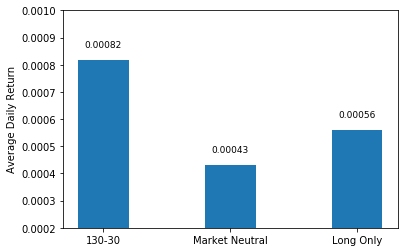

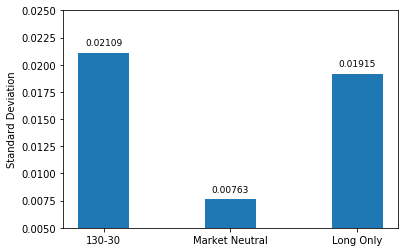

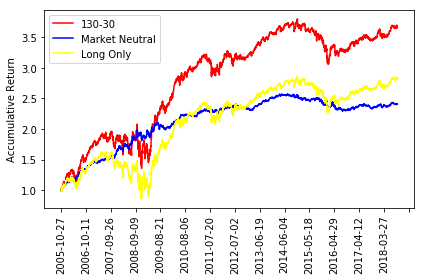

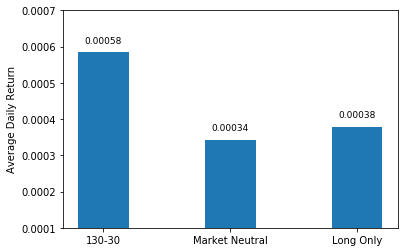

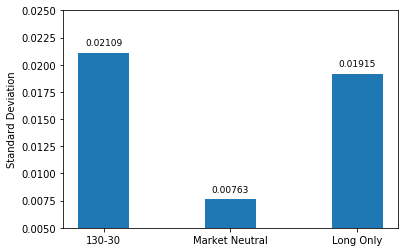

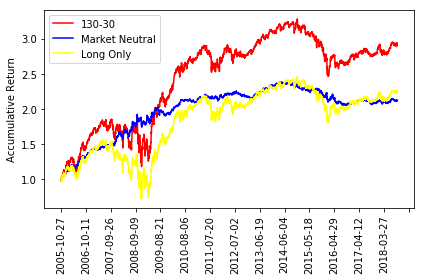

In [5]:
# Plot bar chart for return, standard deviation for three strategies, prior to transaction cost
# Daily Return
strategies = ['130-30','Market Neutral','Long Only']
return_ar = [long_short_nocost_return,neutral_nocost_return,long_only_nocost_return]
plt.bar(strategies,return_ar,align='center', alpha=1.0,width = 0.4)
plt.ylim([0.0002,0.0010])
for a,b in zip(strategies,return_ar):
    plt.text(a, b+0.00004,"%.5f"%b, ha='center', va= 'bottom',fontsize=9)
plt.ylabel('Average Daily Return')
#plt.savefig('C:/Users/Yu/Desktop/Average Daily Return Of Three Strategies Prior To Transaction Cost.png')
plt.show()

# Standard Deviation
sd_ar = [long_short_nocost_sd,neutral_nocost_sd,long_only_nocost_sd]
plt.bar(strategies,sd_ar,align='center', alpha=1.0,width = 0.4)
plt.ylim([0.005,0.025])
for a,b in zip(strategies,sd_ar):
    plt.text(a, b+0.0005,"%.5f"%b, ha='center', va= 'bottom',fontsize=9)
plt.ylabel('Standard Deviation')
#plt.savefig('C:/Users/Yu/Desktop/Standard Deviation Of Three Strategies Prior To Transaction Cost.png')
plt.show()

# Plot line chart for accumulative return from 11/2002 - 10/2018 for three strategies, prior to transaction cost
date_ar = date_list[:-1]
longshort_ar = long_short_accuprofit_nocost.values()
marketneutral_ar = neutral_accuprofit_nocost.values()
longonly_ar = long_only_accuprofit_nocost.values()
plt.plot(date_ar,longshort_ar, color = 'red',label = '130-30')
plt.plot(date_ar,marketneutral_ar, color = 'blue',label = 'Market Neutral')
plt.plot(date_ar,longonly_ar, color = 'yellow',label = 'Long Only')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(240))
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Accumulative Return')
plt.tight_layout()
#plt.savefig('C:/Users/Yu/Desktop/Accumulative Return Of Three Strategies Prior To Transaction Cost.png')
plt.show()

# Plot bar chart for return, standard deviation for three strategies, after transaction cost
# Daily Return
strategies_ar_cost = ['130-30','Market Neutral','Long Only']
return_ar_cost = [long_short_cost_return,neutral_cost_return,long_only_cost_return]
plt.bar(strategies_ar_cost,return_ar_cost,align='center', alpha=1.0,width = 0.4)
plt.ylim([0.0001,0.0007])
for a,b in zip(strategies_ar_cost,return_ar_cost):
    plt.text(a, b+0.00002,"%.5f"%b, ha='center', va= 'bottom',fontsize=9)
plt.ylabel('Average Daily Return')
#plt.savefig('C:/Users/Yu/Desktop/Average Daily Return Of Three Strategies After Transaction Cost.png')
plt.show()

# Standard Deviation
sd_ar_cost = [long_short_cost_sd,neutral_cost_sd,long_only_cost_sd]
plt.bar(strategies_ar_cost,sd_ar_cost,align='center', alpha=1.0,width = 0.4)
plt.ylim([0.005,0.025])
for a,b in zip(strategies_ar_cost,sd_ar_cost):
    plt.text(a, b+0.0005,"%.5f"%b, ha='center', va= 'bottom',fontsize=9)
plt.ylabel('Standard Deviation')
#plt.savefig('C:/Users/Yu/Desktop/Standard Deviation Of Three Strategies After Transaction Cost.png')
plt.show()

# Plot line chart for accumulative return from 11/2002 - 10/2018 for three strategies, after transaction cost
date_ar_cost = date_list[:-1]
longshort_ar_cost = long_short_accuprofit_cost.values()
marketneutral_ar_cost = neutral_accuprofit_cost.values()
longonly_ar_cost = long_only_accuprofit_cost.values()
plt.plot(date_ar_cost,longshort_ar_cost, color = 'red',label = '130-30')
plt.plot(date_ar_cost,marketneutral_ar_cost, color = 'blue',label = 'Market Neutral')
plt.plot(date_ar_cost,longonly_ar_cost, color = 'yellow',label = 'Long Only')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(240))
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Accumulative Return')
plt.tight_layout()
#plt.savefig('C:/Users/Yu/Desktop/Accumulative Return Of Three Strategies After Transaction Cost.png')
plt.show()
